---------------

**If any part of this notebook is used in your research, please cite with the reference found in** **[README.md](https://github.com/pysal/spaghetti#bibtex-citation).**

----------------

## The Traveling Sales(man)(person) Problem — TSP
### Integrating `pysal/spaghetti` and [pulp](https://github.com/coin-or/pulp) for optimal routing

**Author: James D. Gaboardi** **<jgaboardi@gmail.com>**

**This notebook provides a use case for:**

1. Introducing the TSP
2. Declaration or a solution class and model parameters
3. Solving the TSP for an optimal tour

In [1]:
%load_ext watermark
%watermark

2020-01-25T17:07:52-05:00

CPython 3.7.3
IPython 7.10.2

compiler   : Clang 9.0.0 (tags/RELEASE_900/final)
system     : Darwin
release    : 19.2.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


**In addtion to the base** **[spaghetti requirements](https://github.com/pysal/spaghetti/blob/master/requirements.txt)** **(and their dependecies), this notebook requires installations of:**

* [geopandas](http://geopandas.org)
    * `$ conda install -c conda-forge geopandas`
* [matplotlib](https://matplotlib.org)
    * `$ conda install matplotlib`
* [pulp](https://anaconda.org/conda-forge/pulp)
    * `$ conda install -c conda-forge pulp`    

-----------------------

In [2]:
import spaghetti
import geopandas
from libpysal import examples
import matplotlib
import numpy
import pulp
try:
    from IPython.display import set_matplotlib_formats

    set_matplotlib_formats("retina")
except ImportError:
    pass
%matplotlib inline
%watermark -w
%watermark -iv

watermark 2.0.2
geopandas  0.6.2
pulp       1.6.8
matplotlib 3.1.2
spaghetti  1.4.0
numpy      1.17.3



-----------------------------

### 1 Introduction
#### Scenario
Detective George B. Königsberg thought he needed to visit **7** crimes scenes in one area of City X this afternoon in order to collect evidence. However, his lieutenant, Anna Nagurney just told him he needs to double that to **14**. He really wants to wrap up early so he can get home to watch the 2012 mathematical thriller, [Travelling Salesman by Timothy Lanzone](https://en.wikipedia.org/wiki/Travelling_Salesman_(2012_film)), with his cat and dog, Euler and Hamilton. Therefore, he decides on calculating an optimal route so that he can visit all **14** crime scenes in one tour while covering the shortest distance. Det. Königsberg utilizes an integer linear programming formulation of the traveling salesperson problem (TSP) to find his best route.

--------------------------------

#### Integer Linear Programming Formulation based on Miller, Tucker, and Zemlin (1960).

$\begin{array}
\displaystyle \normalsize \textrm{Minimize} & \displaystyle \normalsize \sum_{0 \leq i \\ i \neq j}^n \sum_{j \leq n \\ j \neq i}^n c_{ij}x_{ij}  & & & &  \normalsize (1) \\
\normalsize \textrm{Subject To} & \displaystyle \normalsize \sum_{i=0}^n x_{ij}=1 & \normalsize j=1,...,n, & \normalsize j\neq i;  & &\normalsize (2)\\
& \displaystyle \normalsize \sum_{j=0}^n x_{ij}=1 & \normalsize i=1,...,n, & \normalsize i\neq j; & &\normalsize (3) \\
& \displaystyle \normalsize u_i - u_j + p x_{ij} \leq p - 1 & \normalsize i=1,...,n, & \normalsize 1 \leq i \neq j \leq n; & &\normalsize (4) \\
& \normalsize x_{ij} \in \{0,1\} & \normalsize i=1,...,n, & \normalsize j=1,...,n; & &\normalsize (5)\\
& \normalsize u_{i} \in \mathbb{Z} & \normalsize i=1,...,n. & & &\normalsize (6)\\
\end{array}$

$\begin{array}
\displaystyle \normalsize \textrm{Where} & \small x_{ij} & \small = & \small \begin{cases}
    1, & \textrm{if node } i \textrm{ immediately precedes node } j \textrm{ in the tour}\\
    0, & \textrm{otherwise}
  \end{cases} &&&&\\
& \small c_{ij} & \small = & \small \textrm{distance matrix between all } i,j \textrm{ pairs} &&&& \\
& \small n & \small = & \small \textrm{the total number of nodes in the tour} &&&&\\
& \small i & \small = & \small \textrm{each potential origin node} &&&&\\
& \small j & \small = & \small \textrm{each potential destination node} &&&&\\
& \small u_i & \small = & \small \textrm{continuous, non-negative real numbers} &&&&\\
& \small p & \small = & \small \textrm{allowed visits prior to return (}n = p \textrm{ in this formulation)}  &&&&\\
\end{array}$


---------------------------------

**References**

* **Cummings, N.** (2000) [*A brief History of the Travelling Salesman Problem*](https://www.theorsociety.com/about-or/or-methods/heuristics/a-brief-history-of-the-travelling-salesman-problem/). The Operational Research Society. Accessed: 01/2020.
* **Dantzig, G., Fulkerson, R., and Johnson, S.** (1954) *Solution of a Large-Scale Traveling-Salesman Problem*. Journal of the Operational Research Society of America. 2(4)393-410.
* **Flood, Merrill M.** (1956) *The Traveling-Salesman Problem*. 4(1)61-75.
* **Gass, S. I. and Assad, A. A.** (2005) *An Annotated Timeline of Operations Research: An Informal History*. Springer US.
* **Miller, C. E., Tucker, A. W., and Zemlin, R. A.** (1960) *Integer Programming Formulation of Traveling Salesman Problems*. Journal of Association for Computing Machinery. 7(4)326-329.
* **Miller, H. J. and Shaw, S.-L.** (2001) *Geographic Information Systems for Transportation: Principles and Applications*. New York. Oxford University Press.
* **Nemhauser, G. L. and Wolsey, L. A.** (1988) *Integer and Combinatorial Optimization*. John Wiley & Sons, Inc.

-------------------------------------

### 2. A model, data and parameters
#### Solution class

In [3]:
class MTZ_TSP:
    def __init__(self, nodes, cij, xij_tag="x_%s,%s", ui_tag="u_%s"):
        """Instantiate and solve the Traveling Salesperson Problem (TSP)
        based the formulation from Miller, Tucker, and Zemlin (1960).
        
        Parameters
        ----------
        nodes : geopandas.GeoSeries
            All nodes to be visited in the tour.
        cij : numpy.array
            All-to-all distance matrix for nodes.
        xij_tag : str
            Tour decision variable names within the model. Default is
            'x_%s,%s' where %s indicates string formatting.
        ui_tag : str
            Arbitrary real number decision variable names within the model.
            Default is 'u_%s' where %s indicates string formatting.
        
        Attributes
        ----------
        nodes : geopandas.GeoSeries
            See description in above.
        p : int
            The number of nodes in the set.   
        rp_0n : range
            Range of node IDs in ``nodes`` from 0,...,``p``.
        rp_1n : range
            Range of node IDs in ``nodes`` from 1,...,``p``.
        id : str
            Column name for ``nodes``.
        cij : numpy.array
            See description in above.
        xij_tag : str
            See description in above.
        ui_tag : str
            See description in above.
        tsp : pulp.LpProblem
            Integer Linear Programming problem instance.
        xij : numpy.array
            Binary tour decision variables (``pulp.LpVariable``).
        ui : numpy.array
            Continuous arbitrary real number decision variables
            (``pulp.LpVariable``).
        cycle_ods : dict
            Cycle origin-destination lookup keyed by origin with
            destination as the value.
        tour_pairs : list
            OD pairs comprising each abstract tour arc.
        """

        # all nodes to be visited and the distance matrix
        self.nodes, self.cij = nodes, cij
        # number of nodes in the set
        self.p = self.nodes.shape[0]
        # full and truncated range of nodes (p) in the set
        self.rp_0n, self.rp_1n = range(self.p), range(1, self.p)
        # column name for node IDs
        self.id = self.nodes.name
        # alpha tag for decision and dummy variable prefixes
        self.xij_tag, self.ui_tag = xij_tag, ui_tag

        # instantiate a model
        self.tsp = pulp.LpProblem("MTZ_TSP", pulp.LpMinimize)
        # create and set the tour decision variables
        self.tour_dvs()
        # create and set the arbitraty real number decision variables
        self.arn_dvs()
        # set the objective function
        self.objective_func()
        # node entry constraints
        self.entry_exit_constrs(entry=True)
        # node exit constraints
        self.entry_exit_constrs(entry=False)
        # subtour prevention constraints
        self.prevent_subtours()
        # solve
        self.tsp.solve()
        # origin-destination lookup
        self.get_decisions(display=display)
        # extract the sequence of nodes to construct the optimal tour
        self.construct_tour()

    def tour_dvs(self):
        """Create the tour decision variables - eq (5)."""

        def _name(_x):
            """Helper for naming variables"""
            return self.nodes[_x].split("_")[-1]

        xij = numpy.array(
            [
                [
                    pulp.LpVariable(self.xij_tag % (_name(i), _name(j)), cat="Binary")
                    for j in self.rp_0n
                ]
                for i in self.rp_0n
            ]
        )

        self.xij = xij

    def arn_dvs(self):
        """Create arbitrary real number decision variables - eq (6)."""
        ui = numpy.array(
            [pulp.LpVariable(self.ui_tag % (i), lowBound=0) for i in self.rp_0n]
        )

        self.ui = ui

    def objective_func(self):
        """Add the objective function - eq (1)."""
        self.tsp += pulp.lpSum(
            [
                self.cij[i, j] * self.xij[i, j]
                for i in self.rp_0n
                for j in self.rp_0n
                if i != j
            ]
        )

    def entry_exit_constrs(self, entry=True):
        """Add entry and exit constraints - eq (2) and (3)."""
        if entry:
            for i in self.rp_0n:
                self.tsp += (
                    pulp.lpSum([self.xij[i, j] for j in self.rp_0n if i != j]) == 1
                )
        # exit constraints
        else:
            for j in self.rp_0n:
                self.tsp += (
                    pulp.lpSum([self.xij[i, j] for i in self.rp_0n if i != j]) == 1
                )

    def prevent_subtours(self):
        """Add subtour prevention constraints - eq (4)."""
        for i in self.rp_1n:
            for j in self.rp_1n:
                if i != j:
                    self.tsp += (
                        self.ui[i] - self.ui[j] + self.p * self.xij[i, j] <= self.p - 1
                    )

    def get_decisions(self, display=True):
        """Fetch the selected decision variables."""
        cycle_ods = {}
        for var in self.tsp.variables():
            if var.name.startswith(self.ui_tag[0]):
                continue
            if var.varValue > 0:
                if display:
                    print("%s: %s" % (var.name, var.varValue))
                od = var.name.split("_")[-1]
                o, d = [int(tf) for tf in od.split(",")]
                cycle_ods[o] = d
        if display:
            print("Status: %s" % pulp.LpStatus[self.tsp.status])

        self.cycle_ods = cycle_ods

    def construct_tour(self):
        """Construct the tour."""
        tour_pairs = []
        for origin in self.rp_0n:
            tour_pairs.append([])
            try:
                tour_pairs[origin].append(next_origin)
                next_origin = self.cycle_ods[next_origin]
                tour_pairs[origin].append(next_origin)
            except NameError:
                next_origin = self.cycle_ods[origin]
                tour_pairs[origin].append(origin)
                tour_pairs[origin].append(next_origin)

        tour_pairs = {idx: sorted(cp) for idx, cp in enumerate(tour_pairs)}
        self.tour_pairs = tour_pairs

    def extract_tour(self, paths, id_col, leg_label="leg"):
        """Extract the tour (the legs in the journey) as a 
        ``geopandas.GeoDataFrame`` of ``shapely.geometry.LineString`` objects.
        
        Parameters
        ----------
        paths : geopandas.GeoDataFrame
            Shortest-path routes between all observations.
        id_col : str
            ID column name.
        leg_label : str
            Column name for the tour sequence. Default is 'leg'.
        
        Returns
        -------
        tour : geopandas.GeoDataFrame
            Optimal tour of ``self.nodes`` squenced by ``leg_label``.
        """
        paths[leg_label] = int
        # set label of journey leg for each OD pair.
        for leg, cp in self.tour_pairs.items():
            paths.loc[(paths[id_col] == tuple(cp)), leg_label] = leg
        # extract only paths in the tour
        tour = paths[paths[leg_label] != int].copy()
        tour.sort_values(by=[leg_label], inplace=True)

        return tour

#### Streets

In [4]:
streets = geopandas.read_file(examples.get_path("streets.shp"))
streets.crs = "epsg:2223"
streets = streets.to_crs("epsg:2762")

#### Crimes

In [5]:
all_crimes = geopandas.read_file(examples.get_path("crimes.shp"))
all_crimes.crs = "epsg:2223"
all_crimes = all_crimes.to_crs("epsg:2762")

#### Detective Königsberg's cases

In [6]:
numpy.random.seed(1960)
koenigsberg_cases = 7 * 2
subset_idx = numpy.random.choice(all_crimes.index, koenigsberg_cases, replace=False)
crimes_scenes = all_crimes[all_crimes.index.isin(subset_idx)].copy()

#### Instantiate a network object

In [7]:
ntw = spaghetti.Network(in_data=streets)
vertices, arcs = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)

#### Plot

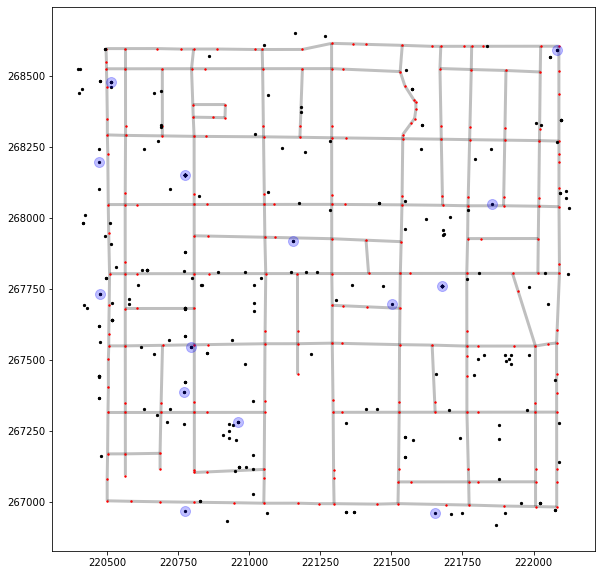

In [8]:
base = arcs.plot(linewidth=3, alpha=0.25, color="k", zorder=0, figsize=(10, 10))
vertices.plot(ax=base, markersize=2, color="red", zorder=1)
all_crimes.plot(ax=base, markersize=5, color="k", zorder=2)
crimes_scenes.plot(ax=base, markersize=100, alpha=0.25, color="blue", zorder=2)

#### Associate Detective Königsberg's cases with the network and plot

In [9]:
ntw.snapobservations(crimes_scenes, "crime_scenes")
pp_obs = spaghetti.element_as_gdf(ntw, pp_name="crime_scenes")
pp_obs_snapped = spaghetti.element_as_gdf(ntw, pp_name="crime_scenes", snapped=True)

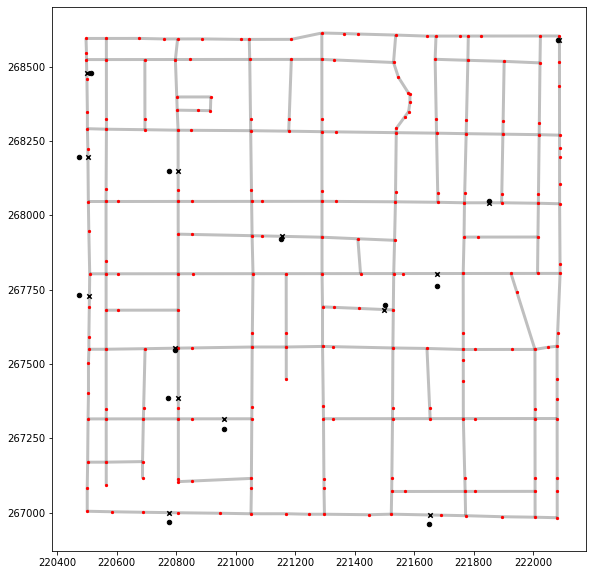

In [10]:
base = arcs.plot(linewidth=3, alpha=0.25, color="k", zorder=0, figsize=(10, 10))
vertices.plot(ax=base, markersize=5, color="r", zorder=1)
pp_obs.plot(ax=base, markersize=20, color="k", zorder=2)
pp_obs_snapped.plot(ax=base, markersize=20, marker="x", color="k", zorder=2)

#### Calculate distance matrix while generating shortest path trees

In [11]:
d2d_dist, tree = ntw.allneighbordistances("crime_scenes", gen_tree=True)
d2d_dist[:3, :3]

array([[          nan,  877.47164862, 1012.61083447],
       [ 877.47164862,           nan,  688.1148453 ],
       [1012.61083447,  688.1148453 ,           nan]])

In [12]:
list(tree.items())[:4], list(tree.items())[-4:]

([((0, 1), (164, 158)),
  ((0, 2), (164, 142)),
  ((0, 3), (164, 197)),
  ((0, 4), (164, 147))],
 [((10, 13), (72, 98)),
  ((11, 12), (26, 29)),
  ((11, 13), (26, 85)),
  ((12, 13), (30, 85))])

--------------------------------
### 3. The Travling Salesperson Problem
#### Create decision variables for the crime scene locations

In [13]:
pp_obs["dv"] = pp_obs["id"].apply(lambda _id: "x_%s" % _id)
pp_obs

id                       geometry    dv
0    0  POINT (221651.779 266962.433)   x_0
1    1  POINT (220774.565 266967.614)   x_1
2    2  POINT (220962.017 267280.644)   x_2
3    3  POINT (220772.431 267386.410)   x_3
4    4  POINT (220796.815 267545.820)   x_4
5    5  POINT (221500.903 267697.915)   x_5
6    6  POINT (220474.032 267730.529)   x_6
7    7  POINT (221677.382 267761.314)   x_7
8    8  POINT (221154.041 267919.810)   x_8
9    9  POINT (221852.947 268049.045)   x_9
10  10  POINT (220775.174 268149.629)  x_10
11  11  POINT (220472.813 268197.482)  x_11
12  12  POINT (220514.875 268478.203)  x_12
13  13  POINT (222083.681 268590.979)  x_13

#### Solve the TSP

In [14]:
mtz_tsp = MTZ_TSP(pp_obs["dv"], d2d_dist)

x_0,1: 1.0
x_1,2: 1.0
x_10,8: 1.0
x_11,12: 1.0
x_12,10: 1.0
x_13,7: 1.0
x_2,3: 1.0
x_3,4: 1.0
x_4,6: 1.0
x_5,0: 1.0
x_6,11: 1.0
x_7,5: 1.0
x_8,9: 1.0
x_9,13: 1.0
Status: Optimal


####  Extract all network shortest paths

In [15]:
paths = ntw.shortest_paths(tree, "crime_scenes")
paths_gdf = spaghetti.element_as_gdf(ntw, routes=paths)
paths_gdf.head()

id                                           geometry
0  (0, 1)  LINESTRING (221652.388 266992.490, 221523.237 ...
1  (0, 2)  LINESTRING (221652.388 266992.490, 221523.237 ...
2  (0, 3)  LINESTRING (221652.388 266992.490, 221523.237 ...
3  (0, 4)  LINESTRING (221652.388 266992.490, 221523.237 ...
4  (0, 5)  LINESTRING (221652.388 266992.490, 221523.237 ...

####  Extract the tour

In [16]:
tour = mtz_tsp.extract_tour(paths_gdf, "id")
tour.head()

id                                           geometry leg
0   (0, 1)  LINESTRING (221652.388 266992.490, 221523.237 ...   0
13  (1, 2)  LINESTRING (220775.021 267000.303, 220807.418 ...   1
25  (2, 3)  LINESTRING (220961.989 267315.817, 220853.037 ...   2
36  (3, 4)  LINESTRING (220807.120 267386.436, 220806.992 ...   3
47  (4, 6)  LINESTRING (220796.691 267553.295, 220695.386 ...   4

#### Define label helper functions and plot Det. Königsberg's optimal tour

In [17]:
def tour_labels(t, b):
    """Label each leg of the tour."""

    def _lab_loc(_x):
        """Helper for labeling location."""
        return _x.geometry.interpolate(0.5, normalized=True).coords[0]

    kws = {"size": 20, "ha": "center", "va": "bottom", "weight": "bold"}
    t.apply(lambda x: b.annotate(s=x.leg, xy=_lab_loc(x), **kws), axis=1)


def obs_labels(o, b):
    """Label each point pattern observation."""

    def _lab_loc(_x):
        """Helper for labeling observations."""
        return _x.geometry.coords[0]

    kws = {"size": 14, "ha": "left", "va": "bottom", "style": "oblique", "color": "k"}
    o.apply(lambda x: b.annotate(s=x.id, xy=_lab_loc(x), **kws), axis=1)

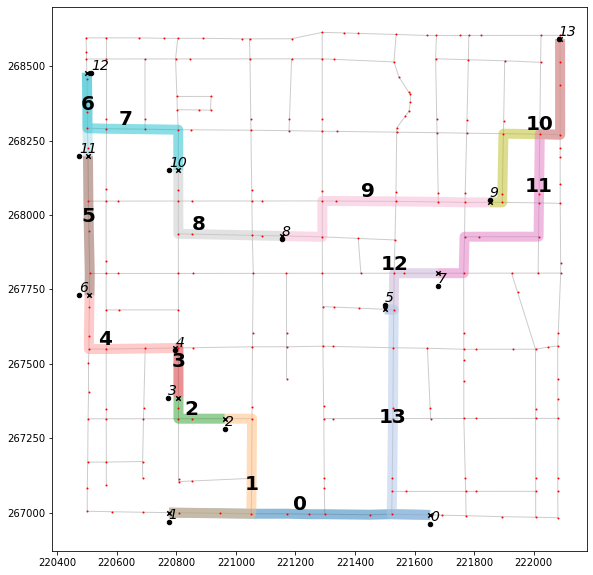

In [18]:
base = arcs.plot(alpha=0.2, linewidth=1, color="k", figsize=(10, 10), zorder=0)
tour.plot(ax=base, column="id", cmap="tab20", alpha=0.50, linewidth=10, zorder=1)
vertices.plot(ax=base, markersize=1, color="r", zorder=2)
pp_obs.plot(ax=base, markersize=20, color="k", zorder=3)
pp_obs_snapped.plot(ax=base, markersize=20, color="k", marker="x", zorder=2)
# tour leg labels
tour_labels(tour, base)
# crime scene labels
obs_labels(pp_obs, base)

----------------------